# CelebA-Spoof for Anti Spoofing using MobileNetV2

Muhammad Adisatriyo Pratama - May 2021
____________________
## Face Antispoofing using Celeb-A Spoof dataset with TensorFlow

CelebA-Spoof Dataset Reference:
- https://github.com/Davidzhangyuanhan/CelebA-Spoof

```script
@inproceedings{CelebA-Spoof,
  title={CelebA-Spoof: Large-Scale Face Anti-Spoofing Dataset with Rich Annotations},
  author={Zhang, Yuanhan and Yin, Zhenfei and Li, Yidong and Yin, Guojun and Yan, Junjie and Shao, Jing and Liu, Ziwei},
  booktitle={European Conference on Computer Vision (ECCV)},
  year={2020}
}
```

## Use GPU

In [1]:
!nvidia-smi

Sat May 15 14:37:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.27       Driver Version: 466.27       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:1F:00.0  On |                  N/A |
| 46%   38C    P8     2W / 130W |    672MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Library

In [2]:
# basic library
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

C:\Users\Roy\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Roy\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Roy\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Dataset Preparation

In [3]:
data_path = 'e:/skripsi/face-anti-spoof-celeba-spoof/dataset-crop/'
TRAIN_DIR = data_path + 'train/'
TEST_DIR = data_path + 'test/'

train_real_dir = os.path.join(TRAIN_DIR, 'real')
train_spoof_dir = os.path.join(TRAIN_DIR, 'spoof')

testing_real_dir = os.path.join(TEST_DIR, 'real')
testing_spoof_dir = os.path.join(TEST_DIR, 'spoof') 

live_train = os.listdir(train_real_dir)
spoof_train = os.listdir(train_spoof_dir)

In [4]:
print('total training real images :', len(os.listdir(train_real_dir)))
print('total training spoof images :', len(os.listdir(train_spoof_dir)))

print('total testing real images :', len(os.listdir(testing_real_dir)))
print('total testing spoof images :', len(os.listdir(testing_spoof_dir)))

total training real images : 30000
total training spoof images : 60000
total testing real images : 3500
total testing spoof images : 6500


## Sample Real and Spoof Images

In [5]:
import cv2


def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

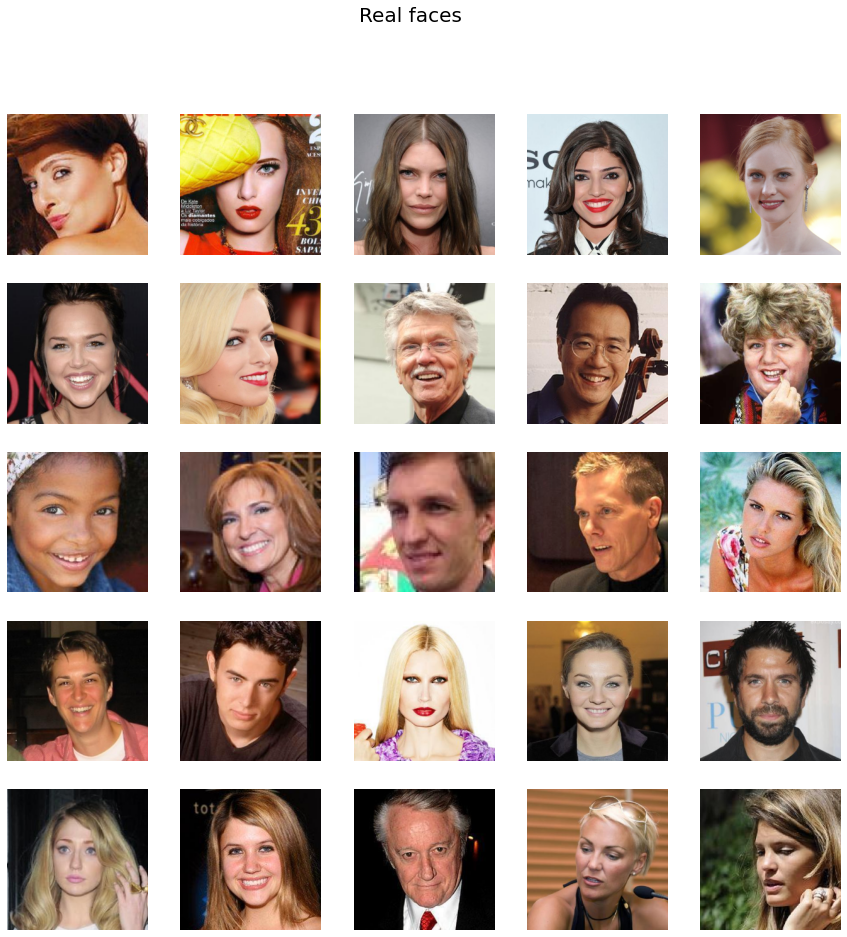

In [6]:
fig = plt.figure(figsize=(15, 15))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(train_real_dir + "/" + live_train[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

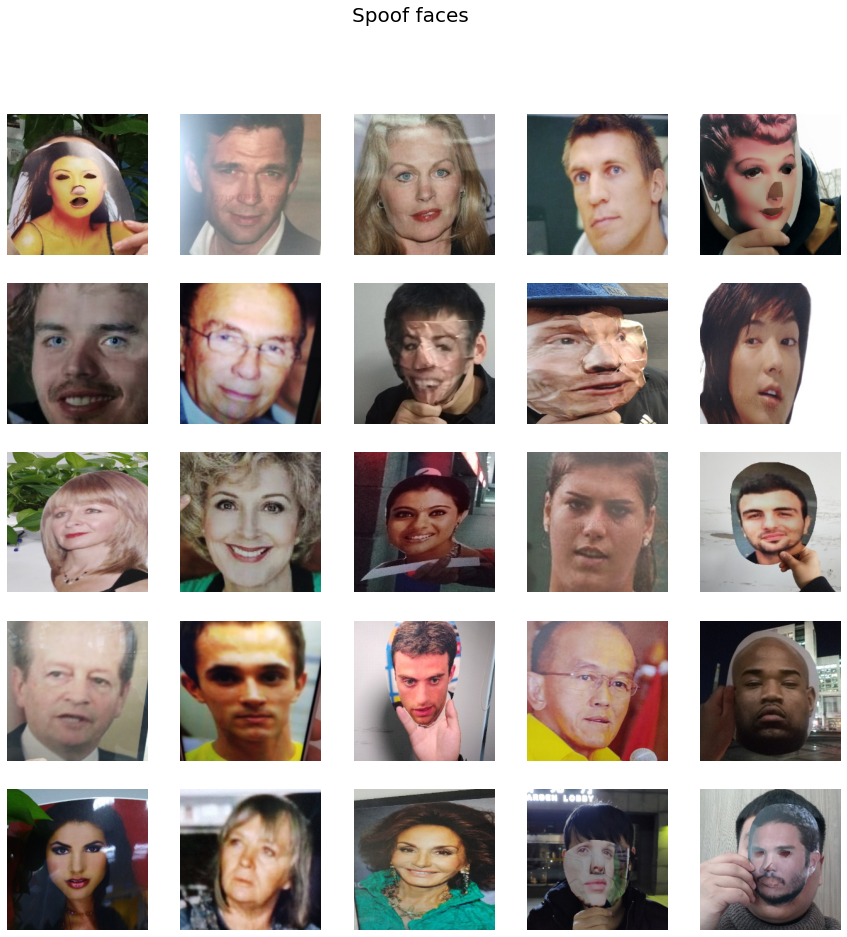

In [7]:
fig = plt.figure(figsize=(15,15))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(train_spoof_dir + "/" + spoof_train[i]), cmap='gray')
    plt.suptitle("Spoof faces",fontsize=20)
    plt.axis('off')

plt.show()

## Preprocessing

In [8]:
# tensorflow library
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.1
Hub version:  0.9.0
GPU is available


In [9]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Variable

In [10]:
# INIT_LR = 1e-4
# SAMPLE_QTD = 1.0

BATCH_SIZE = 32 
IMG_SHAPE = (224, 224, 3)
EPOCHS = 30
RANDOM_STATE = 42
ALPHA = 1e-5

In [11]:
from keras.preprocessing.image import ImageDataGenerator


val_share = 0.2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_share,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 72000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [12]:
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

class_names = ['real', 'spoof']

{'real': 0, 'spoof': 1}
{'real': 0, 'spoof': 1}
{'real': 0, 'spoof': 1}


# MobileNetV2

In [13]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [14]:
model = tf.keras.models.Sequential([mobilenetv2,
                                    tf.keras.layers.GlobalAveragePooling2D(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(128, activation = "relu"),
                                    tf.keras.layers.Dropout(0.1),
                                    tf.keras.layers.Dense(2, activation='softmax')
                                   ])
model.layers[0].trainable = True

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

## Callbacks

In [16]:
filepath="checkpoints/MobileNetV2" + "weights.{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max',
                                                save_weights_only=False)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=ALPHA, patience=5, verbose=1)

## Training

In [18]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [19]:
with tf.device('/GPU:0'):
    hist = model.fit(train_generator,
                    validation_data=val_generator,
                    callbacks = [checkpoint, lr_reduce],
                    epochs=EPOCHS)

Epoch 1/30
2250/2250 [==============================] - 4441s 2s/step - loss: 0.0328 - accuracy: 0.9890 - val_loss: 16.2260 - val_accuracy: 0.3676

Epoch 00001: val_accuracy improved from -inf to 0.36761, saving model to checkpoints\MobileNetV2weights.01-0.3676.h5
Epoch 2/30
2250/2250 [==============================] - 4224s 2s/step - loss: 0.0265 - accuracy: 0.9916 - val_loss: 9.2775 - val_accuracy: 0.5084

Epoch 00002: val_accuracy improved from 0.36761 to 0.50839, saving model to checkpoints\MobileNetV2weights.02-0.5084.h5
Epoch 3/30
2250/2250 [==============================] - 4225s 2s/step - loss: 0.0232 - accuracy: 0.9926 - val_loss: 10.2493 - val_accuracy: 0.4996

Epoch 00003: val_accuracy did not improve from 0.50839
Epoch 4/30
2250/2250 [==============================] - 4344s 2s/step - loss: 0.0180 - accuracy: 0.9939 - val_loss: 2.2250 - val_accuracy: 0.7712

Epoch 00004: val_accuracy improved from 0.50839 to 0.77117, saving model to checkpoints\MobileNetV2weights.04-0.7712.h

## Training Results

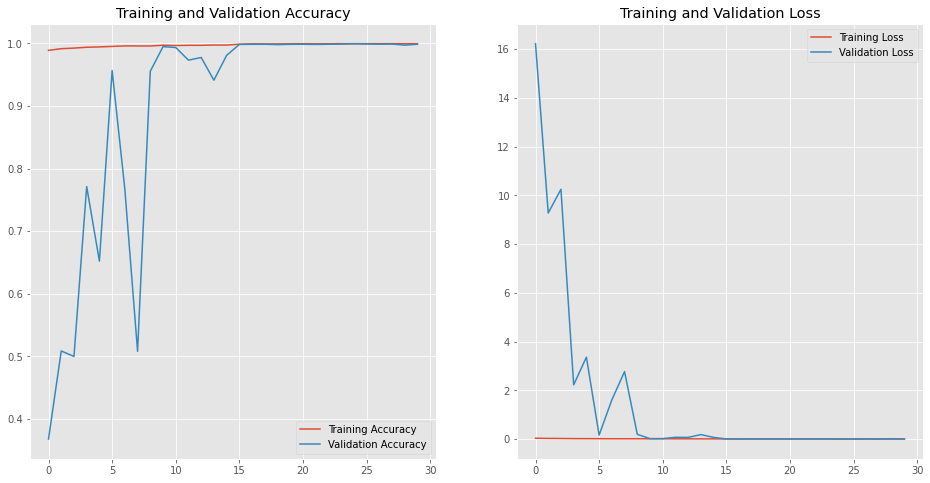

In [20]:
plt.style.use('ggplot')
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [21]:
## Evaluate testing
import time
start_time = time.time()

model.evaluate(test_generator)

print('---- %s seconds ----' % ((time.time() - start_time)))
print('---- %s minutes ----' % ((time.time() - start_time)/60))

313/313 [==============================] - 319s 1s/step - loss: 0.6822 - accuracy: 0.8952
---- 319.9901297092438 seconds ----
---- 5.333185485998789 minutes ----


## Testing Results

In [24]:
# predicted label
y_pred = model.predict(test_generator, verbose=1)
y_pred = y_pred.argmax(axis=1)

# actual label
y_test = test_generator.classes

print(y_pred)
print(y_test)

313/313 [==============================] - 196s 621ms/step
[0 0 0 ... 0 1 1]
[0 0 0 ... 1 1 1]


In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred, target_names=test_generator.class_indices))

              precision    recall  f1-score   support

        real       0.77      1.00      0.87      3500
       spoof       1.00      0.84      0.91      6500

    accuracy                           0.90     10000
   macro avg       0.88      0.92      0.89     10000
weighted avg       0.92      0.90      0.90     10000



## Plot Predicted Image

In [31]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [32]:
predictions = probability_model.predict(test_generator)

In [33]:
def plot_image(i, predictions_array, true_label, img_path):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(load_test_img(img_path), cmap='gray')
    
    # plt.axis('off')
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100 * np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

def load_test_img(path):
    image = cv2.imread(path)
    return image[...,::-1]

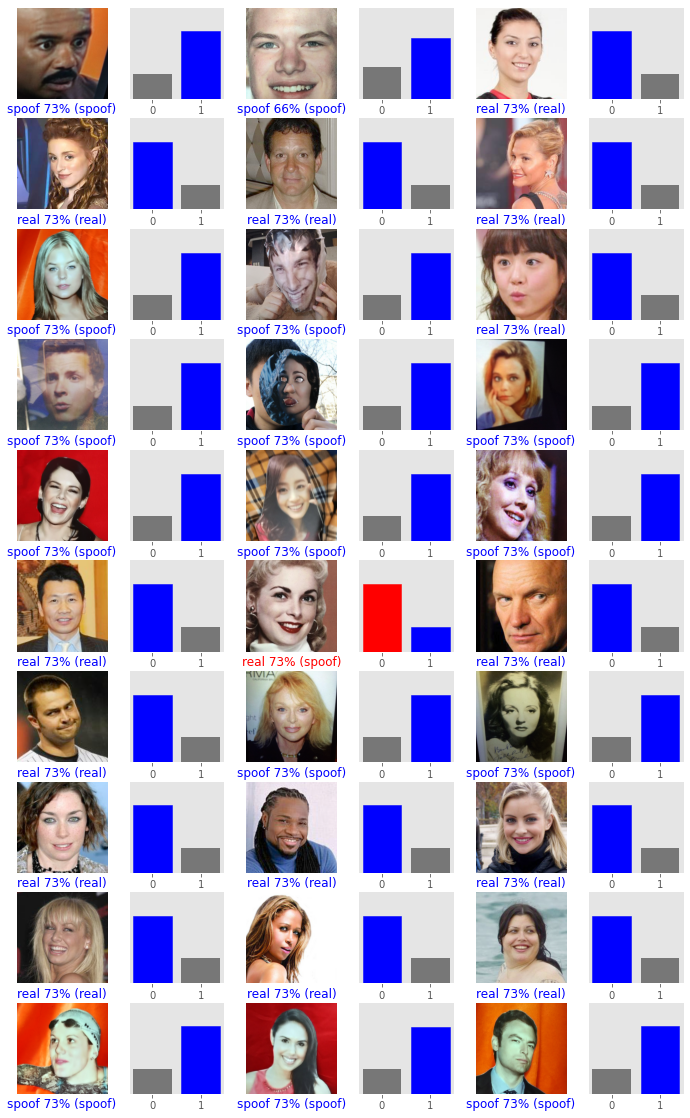

In [34]:
import random

# plot random 30 image from test_generator
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
random_sample = random.sample(range(0, 8050), num_images)

for i in range(num_images):    
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(random_sample[i], predictions[random_sample[i]], y_test, test_generator.filepaths[random_sample[i]])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(random_sample[i], predictions[random_sample[i]], y_test)
        
        
plt.show()

## Save Model

In [35]:
model.save('models/MobileNetV2.h5')